## Churn Analysis and model

For a social network platform, the ability to identify potential user churn and proactively respond to retain those users is a valuable asset.

The solution below supports to identify users at risk of churning. It includes my approach to data analysis, choice of model(s), feature selection, and strategies for user retention.

Please note that we define a user "churned" if they did not visit within the last two months (column CHURNED).


**Solution by Dânia Meira**

**Table of Contents**

1. Checking provided dataset

   1.1 Loading dataset
   
   1.2 Checking column types
   
   1.3 Checking for duplicates
   
   1.4 Checking for missing values
   
   1.5 Checking consistency
   
2. Feature engineering


3. Exploratory analysis

   3.1 Distribution of users by churn status
   
   3.2. Correlation between numerical variables, including the churn variable 
   
   3.3 Exploring the different activity level between churned and non-churned users
   
      3.3.1 Visits
      
      3.3.2 Posts
      
      3.3.3 Likes
   
   
4. Churn model

5. Strategies for user retention

# 1. Checking provided dataset

I loaded the csv data and check for correct data types, missing data, duplicated rows and consistency of the data.

### Result of consistency checks
After confirming with your team, I can see that the dataset provided has users that registered in the period between March 1st, 2022 and February 27th, 2023 (one year time window).


I also noticed that the dataset contains aggregated user information, that is, each row represents a unique user. And in the columns we can find registration timestamp, and then the count and last timestamp for the activities in the platform, such as: visit, post, receiving and giving likes, receivind and writting comments.


Both the aggregation of the user activities and the CHURNED flag are calculated using the same reference date, which is in this case October 31st, 2023, again confirmed by your team. 


### Consequences for the task execution
Given this structure of the data, it is not necessary to predict the churn flag, but simply calculate it using the last visit timestamp. 


Instead, it would make sense to predict the flag at any given point before the reference date on which the churn flag is created. Any moment prior to knowing that the 2 months without activity have passed. This way, a strategy for user retention could prevent users from churning, motivate them to visit the platform again before the 2 months without activity are completed.


- With this data structure, I have conducted an exploratory analysis which can inform about the activity level of churned vs. non-churned users.

- I have also written the code to train a logistic regression, even if that this would not be the model I put in production.

- For productionizing a model, I would need a dataset that has:
  - The same sample of users, selected with the period of registration between March 1st, 2022 and February 27th, 2023 
  - The same churn flag, calculated by applying the churn definition considering the current reference date, October 31st, 2023.
  - All the user variables except from registration, but calculated using an earlier reference date, e.g. 7 days before the churn calculation reference date. In this case it would be October 24th, 2023. 
  - This dataset would enable training a model that tries to predict on October 24th the probability of each of the users, to churn by October 31st.

## 1.1 Loading dataset

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [4]:
df = pd.read_csv('C:/Users/meira/Downloads/2023_senior_data_scientist_challenge.csv')
df.head()

,USER_ID,REGISTRATION_AT,TOTAL_VISIT_COUNT,LAST_VISIT_AT,TOTAL_POST_COUNT,LAST_POST_AT,TOTAL_LIKES_RECEIVED,LAST_LIKE_RECEIVED_AT,TOTAL_COMMENTS_RECEIVED,LAST_COMMENT_RECEIVED_AT,TOTAL_LIKES_GIVEN,LAST_LIKE_GIVEN_AT,TOTAL_COMMENTS_WRITTEN,LAST_COMMENT_WRITTEN_AT,CHURNED
0,1,2022-03-01T03:48:20.679066Z,22,2023-06-12,1,2022-03-09T07:02:02.80497Z,0,NaN,0,NaN,NaN,NaN,NaN,NaN,True
1,2,2022-03-01T05:54:58.396265Z,148,2023-10-29,3,2023-07-16T17:06:24.867194Z,1,2023-07-16T16:59:24.539827Z,0,NaN,4.0,2023-07-16T16:59:24.539827Z,5.0,2023-10-22T05:55:33.144606Z,False
2,3,2022-03-01T06:25:56.171159Z,202,2023-10-25,2,2022-05-02T12:50:11.559472Z,2,2023-05-09T02:46:35.201142Z,1,2022-05-03T08:38:59.565323Z,3.0,2022-07-02T23:32:58.962703Z,11.0,2023-08-20T18:57:50.372676Z,False
3,4,2022-03-01T06:57:51.445332Z,274,2023-10-30,2,2022-11-17T17:37:25.007611Z,7,2022-11-20T07:10:51.768648Z,8,2022-11-30T08:58:08.478337Z,1.0,2022-09-15T09:44:39.575046Z,7.0,2023-09-26T20:56:21.030939Z,False
4,5,2022-03-01T07:19:51.606981Z,46,2023-08-30,4,2023-04-06T04:59:51.919291Z,0,NaN,6,2023-04-06T06:40:43.698873Z,NaN,NaN,4.0,2023-07-26T14:29:46.728719Z,True


In [5]:
df.shape

(50000, 15)

In [6]:
df.columns

Index(['USER_ID', 'REGISTRATION_AT', 'TOTAL_VISIT_COUNT', 'LAST_VISIT_AT',
       'TOTAL_POST_COUNT', 'LAST_POST_AT', 'TOTAL_LIKES_RECEIVED',
       'LAST_LIKE_RECEIVED_AT', 'TOTAL_COMMENTS_RECEIVED',
       'LAST_COMMENT_RECEIVED_AT', 'TOTAL_LIKES_GIVEN', 'LAST_LIKE_GIVEN_AT',
       'TOTAL_COMMENTS_WRITTEN', 'LAST_COMMENT_WRITTEN_AT', 'CHURNED'],
      dtype='object')

## 1.2 Checking column types

Transformations executed:
- Churn boolean to churn int (copy to a new column)
- All variables with timestamp were read as text type, therefore I converted to timestamp type.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   USER_ID                   50000 non-null  int64  
 1   REGISTRATION_AT           50000 non-null  object 
 2   TOTAL_VISIT_COUNT         50000 non-null  int64  
 3   LAST_VISIT_AT             50000 non-null  object 
 4   TOTAL_POST_COUNT          50000 non-null  int64  
 5   LAST_POST_AT              50000 non-null  object 
 6   TOTAL_LIKES_RECEIVED      50000 non-null  int64  
 7   LAST_LIKE_RECEIVED_AT     31528 non-null  object 
 8   TOTAL_COMMENTS_RECEIVED   50000 non-null  int64  
 9   LAST_COMMENT_RECEIVED_AT  38004 non-null  object 
 10  TOTAL_LIKES_GIVEN         32115 non-null  float64
 11  LAST_LIKE_GIVEN_AT        32115 non-null  object 
 12  TOTAL_COMMENTS_WRITTEN    31751 non-null  float64
 13  LAST_COMMENT_WRITTEN_AT   31751 non-null  object 
 14  CHURNE

In [8]:
# The variable of interest, CHURNED, is a boolean. 
# I will create a column with the same values but as int64 to allow for numerical calculation
df['CHURNED_INT'] = df.CHURNED.astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   USER_ID                   50000 non-null  int64  
 1   REGISTRATION_AT           50000 non-null  object 
 2   TOTAL_VISIT_COUNT         50000 non-null  int64  
 3   LAST_VISIT_AT             50000 non-null  object 
 4   TOTAL_POST_COUNT          50000 non-null  int64  
 5   LAST_POST_AT              50000 non-null  object 
 6   TOTAL_LIKES_RECEIVED      50000 non-null  int64  
 7   LAST_LIKE_RECEIVED_AT     31528 non-null  object 
 8   TOTAL_COMMENTS_RECEIVED   50000 non-null  int64  
 9   LAST_COMMENT_RECEIVED_AT  38004 non-null  object 
 10  TOTAL_LIKES_GIVEN         32115 non-null  float64
 11  LAST_LIKE_GIVEN_AT        32115 non-null  object 
 12  TOTAL_COMMENTS_WRITTEN    31751 non-null  float64
 13  LAST_COMMENT_WRITTEN_AT   31751 non-null  object 
 14  CHURNE

In [9]:
# 1- Select column names that start with "LAST"
timestamp_column_names = [col for col in df.columns if col.startswith('LAST')]

# 2- Transform columns with timestamp string into datetime type
print(timestamp_column_names)

df[timestamp_column_names] = df[timestamp_column_names].apply(pd.to_datetime, errors='coerce')

# Registration is also a timestamp
df['REGISTRATION_AT'] = pd.to_datetime(df['REGISTRATION_AT'], errors='coerce')

df.info()

['LAST_VISIT_AT', 'LAST_POST_AT', 'LAST_LIKE_RECEIVED_AT', 'LAST_COMMENT_RECEIVED_AT', 'LAST_LIKE_GIVEN_AT', 'LAST_COMMENT_WRITTEN_AT']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   USER_ID                   50000 non-null  int64              
 1   REGISTRATION_AT           50000 non-null  datetime64[ns, UTC]
 2   TOTAL_VISIT_COUNT         50000 non-null  int64              
 3   LAST_VISIT_AT             50000 non-null  datetime64[ns]     
 4   TOTAL_POST_COUNT          50000 non-null  int64              
 5   LAST_POST_AT              50000 non-null  datetime64[ns, UTC]
 6   TOTAL_LIKES_RECEIVED      50000 non-null  int64              
 7   LAST_LIKE_RECEIVED_AT     31528 non-null  datetime64[ns, UTC]
 8   TOTAL_COMMENTS_RECEIVED   50000 non-null  int64              
 9   LAST_COMMENT_

In [10]:
# get the column LAST_VISIT_AT in the same format as the other timestamp columns
df['LAST_VISIT_AT'] = df['LAST_VISIT_AT'].dt.tz_localize('UTC')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   USER_ID                   50000 non-null  int64              
 1   REGISTRATION_AT           50000 non-null  datetime64[ns, UTC]
 2   TOTAL_VISIT_COUNT         50000 non-null  int64              
 3   LAST_VISIT_AT             50000 non-null  datetime64[ns, UTC]
 4   TOTAL_POST_COUNT          50000 non-null  int64              
 5   LAST_POST_AT              50000 non-null  datetime64[ns, UTC]
 6   TOTAL_LIKES_RECEIVED      50000 non-null  int64              
 7   LAST_LIKE_RECEIVED_AT     31528 non-null  datetime64[ns, UTC]
 8   TOTAL_COMMENTS_RECEIVED   50000 non-null  int64              
 9   LAST_COMMENT_RECEIVED_AT  38004 non-null  datetime64[ns, UTC]
 10  TOTAL_LIKES_GIVEN         32115 non-null  float64            
 11  LAST_LIKE_GIVEN

In [11]:
df.head()

,USER_ID,REGISTRATION_AT,TOTAL_VISIT_COUNT,LAST_VISIT_AT,TOTAL_POST_COUNT,LAST_POST_AT,TOTAL_LIKES_RECEIVED,LAST_LIKE_RECEIVED_AT,TOTAL_COMMENTS_RECEIVED,LAST_COMMENT_RECEIVED_AT,TOTAL_LIKES_GIVEN,LAST_LIKE_GIVEN_AT,TOTAL_COMMENTS_WRITTEN,LAST_COMMENT_WRITTEN_AT,CHURNED,CHURNED_INT
0,1,2022-03-01 03:48:20.679066+00:00,22,2023-06-12 00:00:00+00:00,1,2022-03-09 07:02:02.804970+00:00,0,NaT,0,NaT,NaN,NaT,NaN,NaT,True,1
1,2,2022-03-01 05:54:58.396265+00:00,148,2023-10-29 00:00:00+00:00,3,2023-07-16 17:06:24.867194+00:00,1,2023-07-16 16:59:24.539827+00:00,0,NaT,4.0,2023-07-16 16:59:24.539827+00:00,5.0,2023-10-22 05:55:33.144606+00:00,False,0
2,3,2022-03-01 06:25:56.171159+00:00,202,2023-10-25 00:00:00+00:00,2,2022-05-02 12:50:11.559472+00:00,2,2023-05-09 02:46:35.201142+00:00,1,2022-05-03 08:38:59.565323+00:00,3.0,2022-07-02 23:32:58.962703+00:00,11.0,2023-08-20 18:57:50.372676+00:00,False,0
3,4,2022-03-01 06:57:51.445332+00:00,274,2023-10-30 00:00:00+00:00,2,2022-11-17 17:37:25.007611+00:00,7,2022-11-20 07:10:51.768648+00:00,8,2022-11-30 08:58:08.478337+00:00,1.0,2022-09-15 09:44:39.575046+00:00,7.0,2023-09-26 20:56:21.030939+00:00,False,0
4,5,2022-03-01 07:19:51.606981+00:00,46,2023-08-30 00:00:00+00:00,4,2023-04-06 04:59:51.919291+00:00,0,NaT,6,2023-04-06 06:40:43.698873+00:00,NaN,NaT,4.0,2023-07-26 14:29:46.728719+00:00,True,1


## 1.3 Checking for duplicates

- No duplicates found in this dataset. 

In [12]:
# Finding duplicates
df_dups = df[df.duplicated()]
df_dups.shape

(0, 16)

## 1.4 Checking for missing values

Some columns are missing data, which is justified by the following:
- LAST_LIKE_RECEIVED_AT -> the user has never received a "like". From 50k, 18,472 users. 
- LAST_COMMENT_RECEIVED_AT -> the user has never received a comment. From 50k, 11,996 users. 
- TOTAL_LIKES_GIVEN and LAST_LIKE_GIVEN_AT ->the user has never given a "like". From 50k, 17,885 users. 
- TOTAL_COMMENTS_WRITTEN and LAST_COMMENT_WRITTEN_AT -> the user never wrote a comment. From 50k, 18,249 users. 

Being justified, I kept the rows and left the data as is.

In [13]:
df.isnull().sum()

USER_ID                         0
REGISTRATION_AT                 0
TOTAL_VISIT_COUNT               0
LAST_VISIT_AT                   0
TOTAL_POST_COUNT                0
LAST_POST_AT                    0
TOTAL_LIKES_RECEIVED            0
LAST_LIKE_RECEIVED_AT       18472
TOTAL_COMMENTS_RECEIVED         0
LAST_COMMENT_RECEIVED_AT    11996
TOTAL_LIKES_GIVEN           17885
LAST_LIKE_GIVEN_AT          17885
TOTAL_COMMENTS_WRITTEN      18249
LAST_COMMENT_WRITTEN_AT     18249
CHURNED                         0
CHURNED_INT                     0
dtype: int64

In [14]:
df.describe()

,USER_ID,TOTAL_VISIT_COUNT,TOTAL_POST_COUNT,TOTAL_LIKES_RECEIVED,TOTAL_COMMENTS_RECEIVED,TOTAL_LIKES_GIVEN,TOTAL_COMMENTS_WRITTEN,CHURNED_INT
count,50000.000000,50000.000000,50000.0000,50000.000000,50000.000000,32115.000000,31751.000000,50000.000000
mean,25000.500000,80.323280,3.2949,4.047600,6.966360,10.091733,7.419388,0.500000
std,14433.901067,99.401578,12.3165,20.300791,19.458295,41.725648,21.283468,0.500005
min,1.000000,1.000000,1.0000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,12500.750000,15.000000,1.0000,0.000000,1.000000,1.000000,1.000000,0.000000
50%,25000.500000,39.000000,2.0000,1.000000,3.000000,3.000000,3.000000,0.500000
75%,37500.250000,104.000000,3.0000,4.000000,7.000000,8.000000,7.000000,1.000000
max,50000.000000,595.000000,2444.0000,3814.000000,2909.000000,3359.000000,1448.000000,1.000000


In [15]:
# I will replace the missing numerical values for zero.
df.fillna({'TOTAL_LIKES_GIVEN':0,'TOTAL_COMMENTS_WRITTEN':0}, inplace=True)
df.describe()

,USER_ID,TOTAL_VISIT_COUNT,TOTAL_POST_COUNT,TOTAL_LIKES_RECEIVED,TOTAL_COMMENTS_RECEIVED,TOTAL_LIKES_GIVEN,TOTAL_COMMENTS_WRITTEN,CHURNED_INT
count,50000.000000,50000.000000,50000.0000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000
mean,25000.500000,80.323280,3.2949,4.047600,6.966360,6.48192,4.711460,0.500000
std,14433.901067,99.401578,12.3165,20.300791,19.458295,33.78831,17.332352,0.500005
min,1.000000,1.000000,1.0000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,12500.750000,15.000000,1.0000,0.000000,1.000000,0.00000,0.000000,0.000000
50%,25000.500000,39.000000,2.0000,1.000000,3.000000,1.00000,1.000000,0.500000
75%,37500.250000,104.000000,3.0000,4.000000,7.000000,5.00000,4.000000,1.000000
max,50000.000000,595.000000,2444.0000,3814.000000,2909.000000,3359.00000,1448.000000,1.000000


In [16]:
# Confirming only timestamp columns have missing values
df.isnull().sum()

USER_ID                         0
REGISTRATION_AT                 0
TOTAL_VISIT_COUNT               0
LAST_VISIT_AT                   0
TOTAL_POST_COUNT                0
LAST_POST_AT                    0
TOTAL_LIKES_RECEIVED            0
LAST_LIKE_RECEIVED_AT       18472
TOTAL_COMMENTS_RECEIVED         0
LAST_COMMENT_RECEIVED_AT    11996
TOTAL_LIKES_GIVEN               0
LAST_LIKE_GIVEN_AT          17885
TOTAL_COMMENTS_WRITTEN          0
LAST_COMMENT_WRITTEN_AT     18249
CHURNED                         0
CHURNED_INT                     0
dtype: int64

## 1.5 Checking consistency

- No context was provided regarding the data extration and data preparation.
- As a way to understand what i have to work with, I tried to check for the logic behind the sample and the variables provided.

  - REGISTRATION_AT has minimum value 2022-03-01 03:48:20.679066+00:00 and maximum value 2023-02-27 23:43:51.926169+00:00
  - LAST activities have  all the same minimum value: 2022-03-01 and only two options of maximum value, 2023-10-31 or 2023-10-30
  - LAST_VISIT_AT for churned users is 2023-08-30
  - LAST_VISIT_AT for for non-churned users is 2023-10-31
  
Given the data above, I raised the hypothesis that the dataset was created on October 31st, 2023. I got confirmation from your team after asking via email.

### Why is this an issue for creating a predictive model?

- We are trying to predict something that has already happened. Being in this situation, we have two options:
A) Do not use the information from LAST_VISIT_AT as predictive variable, since this is the definition of the target of prediction.
B) Use the information and have a model that is perfect, since it has the data used to generate the flag itself. This is not predicting but simply calculating. 

In [22]:
df.groupby('CHURNED').LAST_VISIT_AT.max()

CHURNED
False   2023-10-31 00:00:00+00:00
True    2023-08-30 00:00:00+00:00
Name: LAST_VISIT_AT, dtype: datetime64[ns, UTC]

In [ ]:
df[timestamp_column_names].describe(datetime_is_numeric=True)

,LAST_VISIT_AT,LAST_POST_AT,LAST_LIKE_RECEIVED_AT,LAST_COMMENT_RECEIVED_AT,LAST_LIKE_GIVEN_AT,LAST_COMMENT_WRITTEN_AT
count,50000,50000,31528,38004,32115,31751
mean,2023-06-20 14:00:59.327999744+00:00,2023-01-30 06:53:29.914753536+00:00,2023-01-30 19:24:53.159370752+00:00,2023-02-02 01:06:13.896481792+00:00,2023-02-25 01:34:23.202323200+00:00,2023-02-26 16:37:09.661687552+00:00
min,2022-03-01 00:00:00+00:00,2022-03-01 10:32:47.916889+00:00,2022-03-01 17:52:48.280949+00:00,2022-03-01 18:13:21.238020+00:00,2022-03-01 09:53:13.675580+00:00,2022-03-01 09:53:55.493177+00:00
25%,2023-03-14 00:00:00+00:00,2022-09-13 20:44:15.529921024+00:00,2022-09-18 08:17:10.485202944+00:00,2022-09-18 14:08:43.034666240+00:00,2022-10-06 11:43:36.851657984+00:00,2022-10-07 16:47:07.857139968+00:00
50%,2023-08-30 12:00:00+00:00,2023-01-29 18:39:01.558031616+00:00,2023-02-01 16:01:36.349075456+00:00,2023-02-04 13:27:01.378778880+00:00,2023-03-02 19:14:26.346758912+00:00,2023-03-05 09:18:32.352211968+00:00
75%,2023-10-26 00:00:00+00:00,2023-06-29 12:21:33.053118208+00:00,2023-06-23 08:51:47.227882240+00:00,2023-06-27 17:40:42.218240512+00:00,2023-07-31 13:15:46.665724416+00:00,2023-08-01 19:38:51.662457088+00:00
max,2023-10-31 00:00:00+00:00,2023-10-30 23:24:12.856179+00:00,2023-10-31 00:21:30.896648+00:00,2023-10-31 00:13:57.081790+00:00,2023-10-30 23:48:14.598640+00:00,2023-10-31 00:07:37.547368+00:00


In [22]:
df.groupby('CHURNED').LAST_VISIT_AT.max()

CHURNED
False   2023-10-31 00:00:00+00:00
True    2023-08-30 00:00:00+00:00
Name: LAST_VISIT_AT, dtype: datetime64[ns, UTC]

# 2. Feature engineering

Creating numerical variables for the timestamps in the format "DAYS_SINCE_LAST_(...)" considering the date reference, that is, the date when the dataset was created (31 October, 2023).

In case the value is missing, I assume that the user has never performed the action, e.g. like. For those cases, we will assign the value -1, which will be the only negative value existent for this variable. This way, we will know that if the value is negative, it means the user never perform the action.

In [26]:
reference_date = df.LAST_VISIT_AT.max()
reference_date

Timestamp('2023-10-31 00:00:00+0000', tz='UTC')

In [27]:
timestamp_column_names

['LAST_VISIT_AT',
 'LAST_POST_AT',
 'LAST_LIKE_RECEIVED_AT',
 'LAST_COMMENT_RECEIVED_AT',
 'LAST_LIKE_GIVEN_AT',
 'LAST_COMMENT_WRITTEN_AT']

In [28]:
for col in timestamp_column_names:
    new_col = ('DAYS_SINCE_'+col)[:-3]
    df[new_col] = (reference_date - df[col]).dt.days.fillna(-1).astype(int)

df.describe()

,USER_ID,TOTAL_VISIT_COUNT,TOTAL_POST_COUNT,TOTAL_LIKES_RECEIVED,TOTAL_COMMENTS_RECEIVED,TOTAL_LIKES_GIVEN,TOTAL_COMMENTS_WRITTEN,CHURNED_INT,DAYS_SINCE_LAST_VISIT,DAYS_SINCE_LAST_POST,DAYS_SINCE_LAST_LIKE_RECEIVED,DAYS_SINCE_LAST_COMMENT_RECEIVED,DAYS_SINCE_LAST_LIKE_GIVEN,DAYS_SINCE_LAST_COMMENT_WRITTEN
count,50000.000000,50000.000000,50000.0000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,80.323280,3.2949,4.047600,6.966360,6.48192,4.711460,0.500000,132.415980,273.281480,171.624880,205.378220,158.617580,155.773140
std,14433.901067,99.401578,12.3165,20.300791,19.458295,33.78831,17.332352,0.500005,153.903945,168.714348,185.851063,185.608978,181.409884,180.332539
min,1.000000,1.000000,1.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,12500.750000,15.000000,1.0000,0.000000,1.000000,0.00000,0.000000,0.000000,5.000000,123.000000,-1.000000,3.000000,-1.000000,-1.000000
50%,25000.500000,39.000000,2.0000,1.000000,3.000000,1.00000,1.000000,0.500000,61.500000,274.000000,105.000000,180.000000,75.000000,71.000000
75%,37500.250000,104.000000,3.0000,4.000000,7.000000,5.00000,4.000000,1.000000,231.000000,412.000000,328.000000,364.000000,300.000000,294.000000
max,50000.000000,595.000000,2444.0000,3814.000000,2909.000000,3359.00000,1448.000000,1.000000,609.000000,608.000000,608.000000,608.000000,608.000000,608.000000


# 3. Exploratory analysis

## 3.1. Distribution of users by churn status

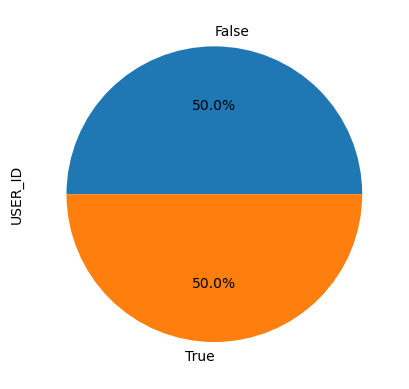

In [19]:
# pie plot churn vs. amount of users
df.groupby('CHURNED')['USER_ID'].nunique().plot(kind='pie', autopct='%0.01f%%');

In [20]:
# Balanced dataset
df.groupby('CHURNED')['USER_ID'].nunique()

CHURNED
False    25000
True     25000
Name: USER_ID, dtype: int64

## 3.2. Correlation between numerical variables, including the churn variable

In [21]:
# Getting only the numerical variables, exclude USER_ID column
df_numerical = df.select_dtypes(include='number')
df_numerical.drop(['USER_ID'], axis='columns', inplace=True)
df_numerical.head()

,TOTAL_VISIT_COUNT,TOTAL_POST_COUNT,TOTAL_LIKES_RECEIVED,TOTAL_COMMENTS_RECEIVED,TOTAL_LIKES_GIVEN,TOTAL_COMMENTS_WRITTEN,CHURNED_INT,DAYS_SINCE_LAST_VISIT,DAYS_SINCE_LAST_POST,DAYS_SINCE_LAST_LIKE_RECEIVED,DAYS_SINCE_LAST_COMMENT_RECEIVED,DAYS_SINCE_LAST_LIKE_GIVEN,DAYS_SINCE_LAST_COMMENT_WRITTEN
0,22,1,0,0,0.0,0.0,1,141,600,-1,-1,-1,-1
1,148,3,1,0,4.0,5.0,0,2,106,106,-1,106,8
2,202,2,2,1,3.0,11.0,0,6,546,174,545,485,71
3,274,2,7,8,1.0,7.0,0,1,347,344,334,410,34
4,46,4,0,6,0.0,4.0,1,62,207,-1,207,-1,96


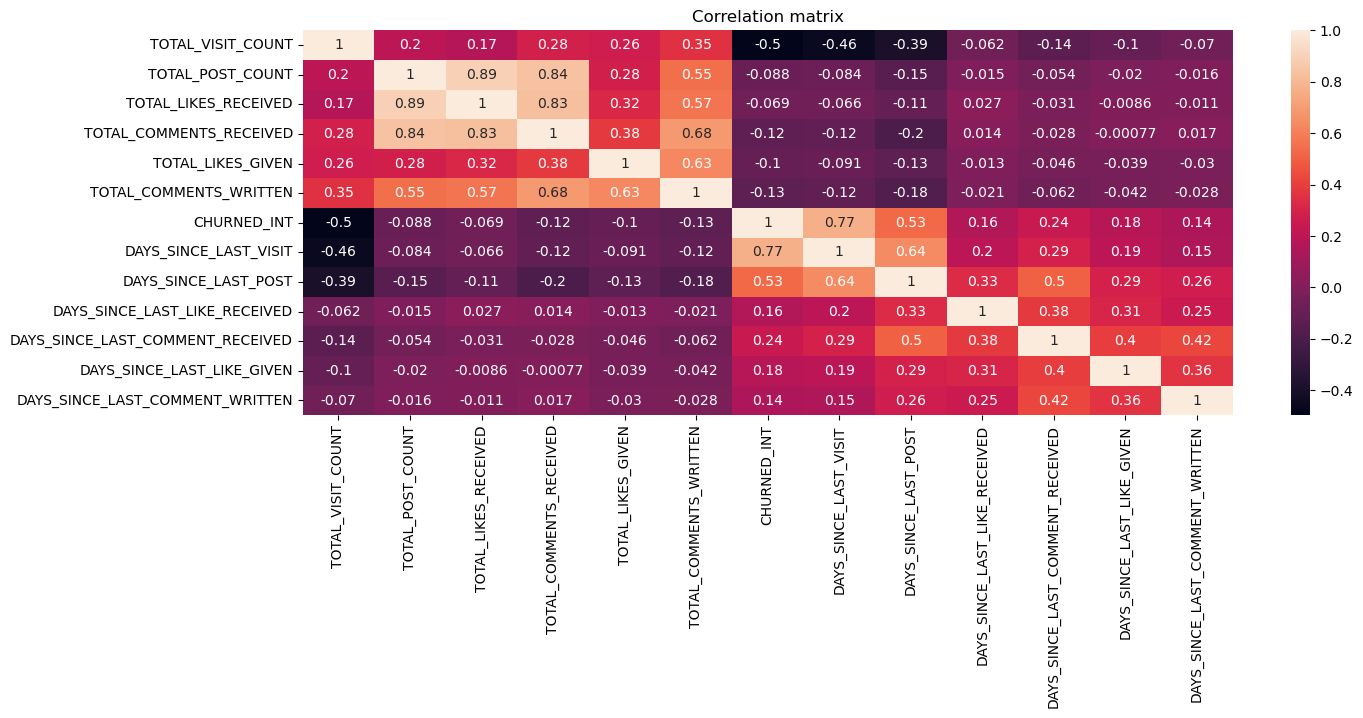

In [22]:
# Create a subplot with matplotlib
f, ax = plt.subplots(figsize=(15,5))

# Create the correlation heatmap in seaborn.
corr = sns.heatmap(df_numerical.corr(), annot = True, ax = ax).set(title = 'Correlation matrix') 

#### Considering the follwing intervals of the absolute value of the correlation coefficient:

0–0.3: negligible correlation

0.3–0.5: weak relationship

0.5–0.7: moderate relationship

0.7–1.0: strong relationship


**Reminder: Correlation does not imply causation.** Correlation between two variables indicates that changes in one variable are associated with changes in the other variable. In this case, we are calculating only the linear correlation, which indicates if any linear changes in one variable affect another.

### The correlation matrix shows a few interesting relationships between the variables of user activity, such as:

- There is a *strong positive (>0.8)* relationship between TOTAL_POST_COUNT, TOTAL_LIKES_RECEIVED, TOTAL_COMMENTS_RECEIVED: It makes sense, since a like or comment can only exist for a post

- There is a *strong to moderate positive (0.68)* relationship between TOTAL_COMMENTS_WRITTEN and TOTAL_COMMENTS_RECEIVED: This can be interpreted as a strong sign of user building relationships in the platform. The more the user comments on posts of others, more the others comment on their post.

- There is a *moderate positive (>0.5)* relationship between TOTAL_COMMENTS_WRITTEN and TOTAL_POST_COUNT, and TOTAL_COMMENTS_WRITTEN and TOTAL_LIKES_RECEIVED: This can be interpreted as a moderate sign of user with a relevant level of activity. The user actively posts and comments on post of others, more others like their posts.

- There is a *weak positive (>0.3)* relationship between TOTAL_LIKES_GIVEN and TOTAL_COMMENTS_RECEIVED, and TOTAL_LIKES_GIVEN and TOTAL_LIKES_RECEIVED: This can be interpreted as a weak sign of user building relationships in the platform. The more the user likes posts of others, more the others like and comment on their post.

- There is a *weak positive (0.35) relationship between TOTAL_VISIT_COUNT and TOTAL_COMMENTS_WRITTEN: This can be interpreted as a weak sign of user visiting the platform only to comment on others' posts.


However, TOTAL_VISIT_COUNT has only neglectible correlation with TOTAL_POST_COUNT and 'TOTAL_LIKES_GIVEN', which can be interpreted as only a neglectible amount of users post or like on their visits.

### Regarding the correlation with the churn, we can see that:
- As expected, the correlation with all user activity is negative. And the correlation with number of days passed since any activity is positive.
- Relatinship with all variables with negative correlation but TOTAL_VISIT_COUNT is neglectible (< -0.3).
- Relatinship with all variables with positive correlation but DAYS_SINCE_LAST_POST and DAYS_SINCE_LAST_VISIT is neglectible (< 0.3).
- TOTAL_VISIT_COUNT and CHURNED have only a *moderate negative* relentionship (-0.5). And because of the definition, we also know that all the visits happened before 2 months ago for the users with CHURNED=1, or True)
- DAYS_SINCE_LAST_POST and CHURNED have only a *moderate positive* relentionship (0.53). 
- DAYS_SINCE_LAST_VISIT and CHURNED have a *strong positive* relentionship (0.77). Which is expected, since the churn definition is >60 since last visit.

## 3.3 Exploring the different activity level between churned and non-churned users

### 3.3.1 Visits

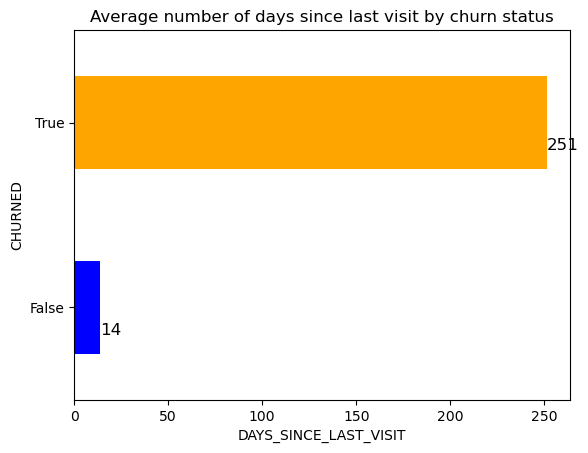

In [23]:
# churn vs. days since last visit
ax = df.groupby('CHURNED')['DAYS_SINCE_LAST_VISIT'].mean().plot.barh(color=['blue', 'orange'])
plt.xlabel('DAYS_SINCE_LAST_VISIT')
plt.title('Average number of days since last visit by churn status')

# Add labels to the bars
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.1, f'{i.get_width():.0f}', fontsize=12, color='black')


# Show the plot
plt.show()

In [24]:
df.groupby('CHURNED').DAYS_SINCE_LAST_VISIT.describe()

,count,mean,std,min,25%,50%,75%,max
CHURNED,,,,,,,,
False,25000.0,13.66448,16.592166,0.0,1.0,5.0,20.0,61.0
True,25000.0,251.16748,137.453738,62.0,130.0,231.0,354.0,609.0


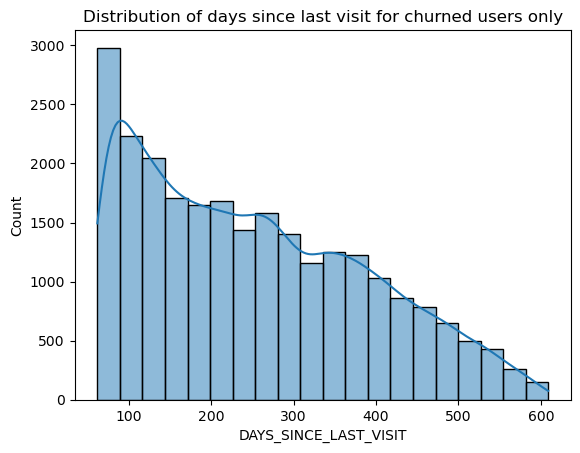

In [25]:
# Making a histogram of days since last visit for churned users only
sns.histplot(df.loc[df.CHURNED==True,'DAYS_SINCE_LAST_VISIT'], bins = 20, kde = True).set(title = 'Distribution of days since last visit for churned users only');

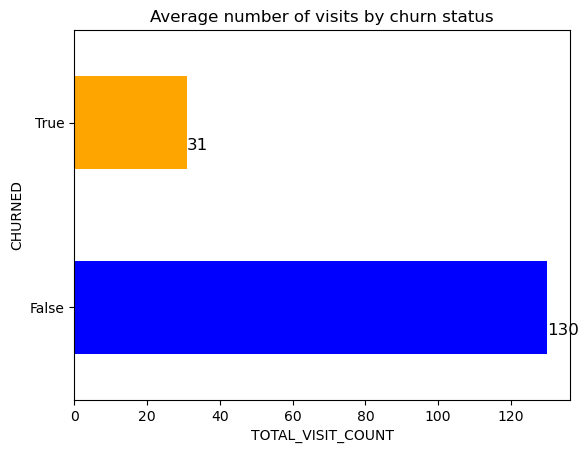

In [26]:
# churn vs. number of visits
ax = df.groupby('CHURNED')['TOTAL_VISIT_COUNT'].mean().plot.barh(color=['blue', 'orange'])
plt.xlabel('TOTAL_VISIT_COUNT')
plt.title('Average number of visits by churn status')

# Add labels to the bars
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.1, f'{i.get_width():.0f}', fontsize=12, color='black')


# Show the plot
plt.show()

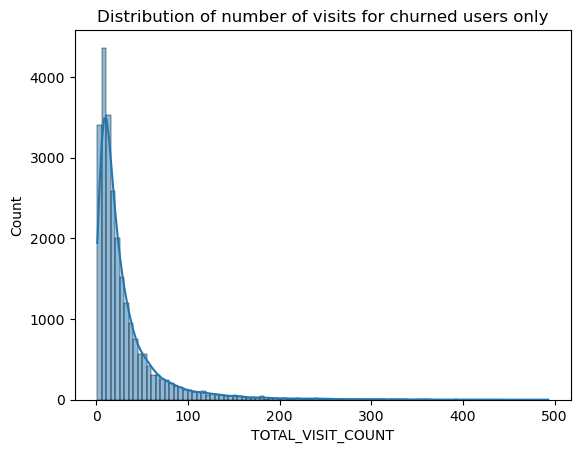

In [27]:
# Making a histogram of number of visits for churned users only
sns.histplot(df.loc[df.CHURNED==True,'TOTAL_VISIT_COUNT'], bins = 100, kde = True).set(title = 'Distribution of number of visits for churned users only');

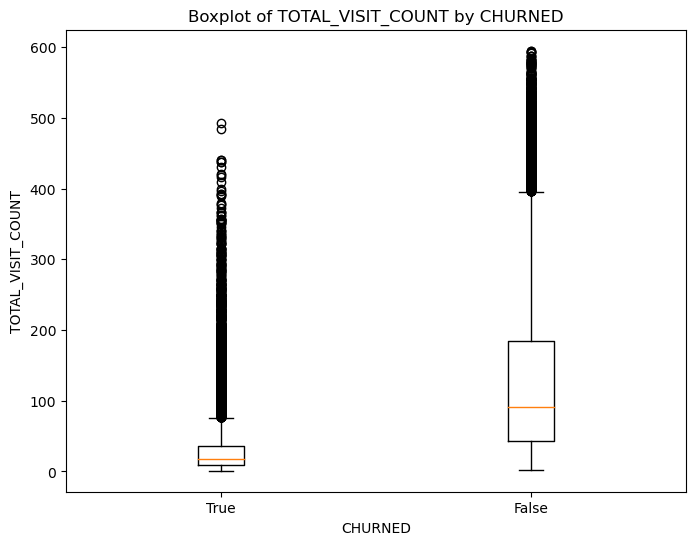

In [28]:
plt.figure(figsize=(8, 6))
plt.boxplot([df.loc[df.CHURNED==True,'TOTAL_VISIT_COUNT'], df.loc[df.CHURNED==False,'TOTAL_VISIT_COUNT']], labels=['True', 'False'])
plt.xlabel('CHURNED')
plt.ylabel('TOTAL_VISIT_COUNT')
plt.title('Boxplot of TOTAL_VISIT_COUNT by CHURNED')
plt.show()

In [29]:
df.groupby('CHURNED')['TOTAL_VISIT_COUNT'].describe()

,count,mean,std,min,25%,50%,75%,max
CHURNED,,,,,,,,
False,25000.0,129.75944,115.004976,2.0,43.0,91.0,184.0,595.0
True,25000.0,30.88712,40.589835,1.0,9.0,18.0,36.0,493.0


In [30]:
### 3.3.1 Giving likes and writing comments

In [31]:
### 3.3.1 Receiving likes and comments

In [32]:
# Check for outliers

##### Investigating distribution and possible outliers

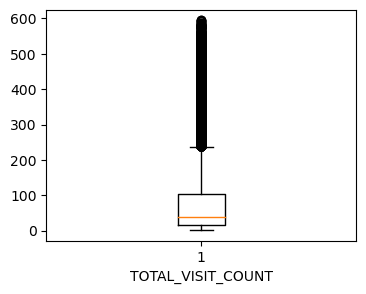

In [33]:
plt.figure(figsize=(4, 3))
plt.boxplot(df['TOTAL_VISIT_COUNT']);
plt.xlabel('TOTAL_VISIT_COUNT');

In [34]:
# Calculate the IQR for each category
Q1_visits = df.TOTAL_VISIT_COUNT.quantile(0.25)
Q3_visits = df.TOTAL_VISIT_COUNT.quantile(0.75)
IQR_visits = Q3_visits - Q1_visits

# Define the upper and lower bounds for outliers
lower_bound_visits = Q1_visits - 1.5 * IQR_visits
upper_bound_visits = Q3_visits + 1.5 * IQR_visits

# Find outliers
outliers_visits = df.loc[(df.TOTAL_VISIT_COUNT < lower_bound_visits) | (df.TOTAL_VISIT_COUNT > upper_bound_visits), 
                         ['TOTAL_VISIT_COUNT','CHURNED_INT']]
outliers_visits.describe()

,TOTAL_VISIT_COUNT,CHURNED_INT
count,4425.000000,4425.000000
mean,338.645424,0.041130
std,82.115324,0.198613
min,238.000000,0.000000
25%,271.000000,0.000000
50%,319.000000,0.000000
75%,389.000000,0.000000
max,595.000000,1.000000


In [35]:
print(upper_bound_visits) # visits above 237 are considered outliers

237.5


In [36]:
outliers_visits.shape[0]/df.shape[0]*100 # they represent 8.85% of the dataset

8.85

In [37]:
outliers_visits.groupby('CHURNED_INT').count()

,TOTAL_VISIT_COUNT
CHURNED_INT,
0,4243
1,182


In [38]:
# without outliers
no_outliers_visits = df.loc[(df.TOTAL_VISIT_COUNT >= lower_bound_visits) & (df.TOTAL_VISIT_COUNT <= upper_bound_visits)]
no_outliers_visits.describe()

,USER_ID,TOTAL_VISIT_COUNT,TOTAL_POST_COUNT,TOTAL_LIKES_RECEIVED,TOTAL_COMMENTS_RECEIVED,TOTAL_LIKES_GIVEN,TOTAL_COMMENTS_WRITTEN,CHURNED_INT,DAYS_SINCE_LAST_VISIT,DAYS_SINCE_LAST_POST,DAYS_SINCE_LAST_LIKE_RECEIVED,DAYS_SINCE_LAST_COMMENT_RECEIVED,DAYS_SINCE_LAST_LIKE_GIVEN,DAYS_SINCE_LAST_COMMENT_WRITTEN
count,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000,45575.000000
mean,25582.472913,55.242084,2.708656,3.232540,5.668261,4.218146,3.136632,0.544553,144.392825,286.144312,174.706703,211.234953,164.253977,160.735425
std,14441.981873,55.472787,3.610895,7.667839,10.408507,14.075737,8.367893,0.498017,155.813983,165.635805,188.702227,188.058201,185.076332,184.127718
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,13148.500000,14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,143.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,25839.000000,34.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,80.000000,288.000000,108.000000,195.000000,84.000000,75.000000
75%,38158.500000,79.000000,3.000000,3.000000,7.000000,4.000000,3.000000,1.000000,251.000000,420.000000,338.000000,372.000000,317.000000,308.000000
max,50000.000000,237.000000,110.000000,258.000000,314.000000,831.000000,534.000000,1.000000,609.000000,608.000000,608.000000,608.000000,608.000000,608.000000


### 3.3.2 Posts

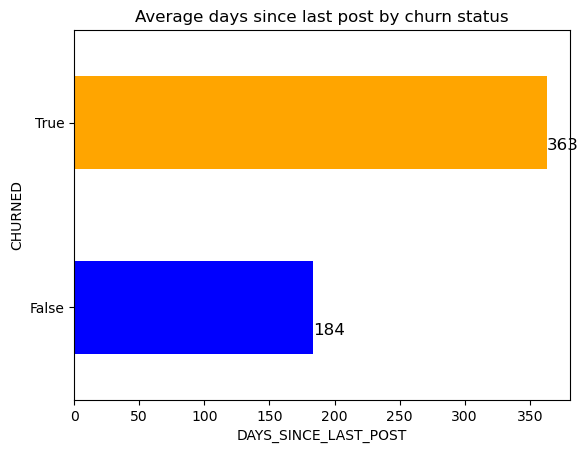

In [46]:
# churn vs. average days since last posts
ax = df.groupby('CHURNED')['DAYS_SINCE_LAST_POST'].mean().plot.barh(color=['blue', 'orange'])
plt.xlabel('DAYS_SINCE_LAST_POST')
plt.title('Average days since last post by churn status')

# Add labels to the bars
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.1, f'{i.get_width():.0f}', fontsize=12, color='black')


# Show the plot
plt.show()

In [40]:
df.describe()

,USER_ID,TOTAL_VISIT_COUNT,TOTAL_POST_COUNT,TOTAL_LIKES_RECEIVED,TOTAL_COMMENTS_RECEIVED,TOTAL_LIKES_GIVEN,TOTAL_COMMENTS_WRITTEN,CHURNED_INT,DAYS_SINCE_LAST_VISIT,DAYS_SINCE_LAST_POST,DAYS_SINCE_LAST_LIKE_RECEIVED,DAYS_SINCE_LAST_COMMENT_RECEIVED,DAYS_SINCE_LAST_LIKE_GIVEN,DAYS_SINCE_LAST_COMMENT_WRITTEN
count,50000.000000,50000.000000,50000.0000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,25000.500000,80.323280,3.2949,4.047600,6.966360,6.48192,4.711460,0.500000,132.415980,273.281480,171.624880,205.378220,158.617580,155.773140
std,14433.901067,99.401578,12.3165,20.300791,19.458295,33.78831,17.332352,0.500005,153.903945,168.714348,185.851063,185.608978,181.409884,180.332539
min,1.000000,1.000000,1.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,12500.750000,15.000000,1.0000,0.000000,1.000000,0.00000,0.000000,0.000000,5.000000,123.000000,-1.000000,3.000000,-1.000000,-1.000000
50%,25000.500000,39.000000,2.0000,1.000000,3.000000,1.00000,1.000000,0.500000,61.500000,274.000000,105.000000,180.000000,75.000000,71.000000
75%,37500.250000,104.000000,3.0000,4.000000,7.000000,5.00000,4.000000,1.000000,231.000000,412.000000,328.000000,364.000000,300.000000,294.000000
max,50000.000000,595.000000,2444.0000,3814.000000,2909.000000,3359.00000,1448.000000,1.000000,609.000000,608.000000,608.000000,608.000000,608.000000,608.000000


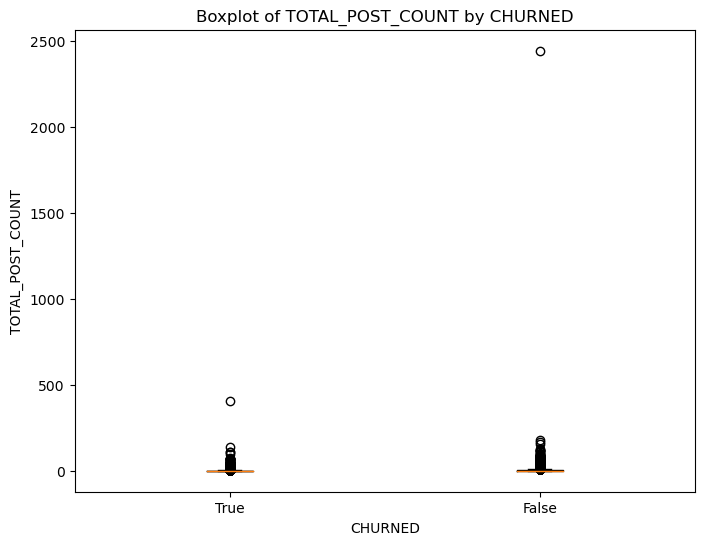

In [41]:
plt.figure(figsize=(8, 6))
plt.boxplot([df.loc[df.CHURNED==True,'TOTAL_POST_COUNT'], df.loc[df.CHURNED==False,'TOTAL_POST_COUNT']], labels=['True', 'False'])
plt.xlabel('CHURNED')
plt.ylabel('TOTAL_POST_COUNT')
plt.title('Boxplot of TOTAL_POST_COUNT by CHURNED')
plt.show()

In [42]:
df.groupby('CHURNED').TOTAL_POST_COUNT.max()

CHURNED
False    2444
True      405
Name: TOTAL_POST_COUNT, dtype: int64

In [43]:
# Removing clear outliers
df_no_outliers = df[df['TOTAL_POST_COUNT'] < 405]
df_no_outliers.groupby('CHURNED').TOTAL_POST_COUNT.max()

CHURNED
False    180
True     140
Name: TOTAL_POST_COUNT, dtype: int64

In [44]:
df_no_outliers.describe()

,USER_ID,TOTAL_VISIT_COUNT,TOTAL_POST_COUNT,TOTAL_LIKES_RECEIVED,TOTAL_COMMENTS_RECEIVED,TOTAL_LIKES_GIVEN,TOTAL_COMMENTS_WRITTEN,CHURNED_INT,DAYS_SINCE_LAST_VISIT,DAYS_SINCE_LAST_POST,DAYS_SINCE_LAST_LIKE_RECEIVED,DAYS_SINCE_LAST_COMMENT_RECEIVED,DAYS_SINCE_LAST_LIKE_GIVEN,DAYS_SINCE_LAST_COMMENT_WRITTEN
count,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000,49998.000000
mean,25001.402916,80.307472,3.238050,3.964179,6.903296,6.454558,4.678007,0.500000,132.417717,273.288892,171.628225,205.382895,158.620125,155.775831
std,14433.483291,99.369263,5.415117,10.917581,14.454407,33.392202,16.053213,0.500005,153.905772,168.712735,185.853194,185.610375,181.412325,180.334775
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,12502.250000,15.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,5.000000,123.000000,-1.000000,3.000000,-1.000000,-1.000000
50%,25001.500000,39.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.500000,61.500000,274.000000,105.000000,180.000000,75.000000,71.000000
75%,37500.750000,104.000000,3.000000,4.000000,7.000000,5.000000,4.000000,1.000000,231.000000,412.000000,328.000000,364.000000,300.000000,294.000000
max,50000.000000,595.000000,180.000000,587.000000,537.000000,3359.000000,946.000000,1.000000,609.000000,608.000000,608.000000,608.000000,608.000000,608.000000


In [45]:
# Category for users based on amount of posts
conditions = [
    (df_no_outliers['TOTAL_POST_COUNT'] < 2),
    (df_no_outliers['TOTAL_POST_COUNT'] >= 2) & (df_no_outliers['TOTAL_POST_COUNT'] < 3),
    (df_no_outliers['TOTAL_POST_COUNT'] >= 3)
]
categories = ['1 post only', 'Up to 3 posts', '3 or more posts']

# Use np.where to create the 'Category' column
df_no_outliers['POST_CAT'] = np.select(conditions, categories, default='Unknown')

pd.crosstab(df_no_outliers['CHURNED'], df_no_outliers['POST_CAT'])

C:\Users\meira\AppData\Local\Temp\ipykernel_28984\3415536074.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['POST_CAT'] = np.select(conditions, categories, default='Unknown')


POST_CAT,1 post only,3 or more posts,Up to 3 posts
CHURNED,,,
False,8344,11639,5016
True,14918,5270,4811


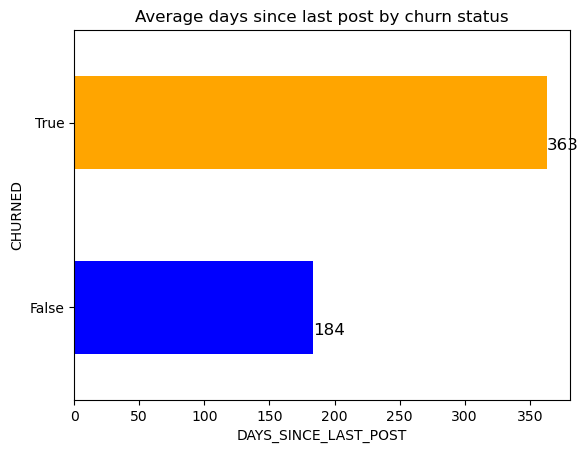

In [46]:
# churn vs. average days since last posts
ax = df.groupby('CHURNED')['DAYS_SINCE_LAST_POST'].mean().plot.barh(color=['blue', 'orange'])
plt.xlabel('DAYS_SINCE_LAST_POST')
plt.title('Average days since last post by churn status')

# Add labels to the bars
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.1, f'{i.get_width():.0f}', fontsize=12, color='black')


# Show the plot
plt.show()

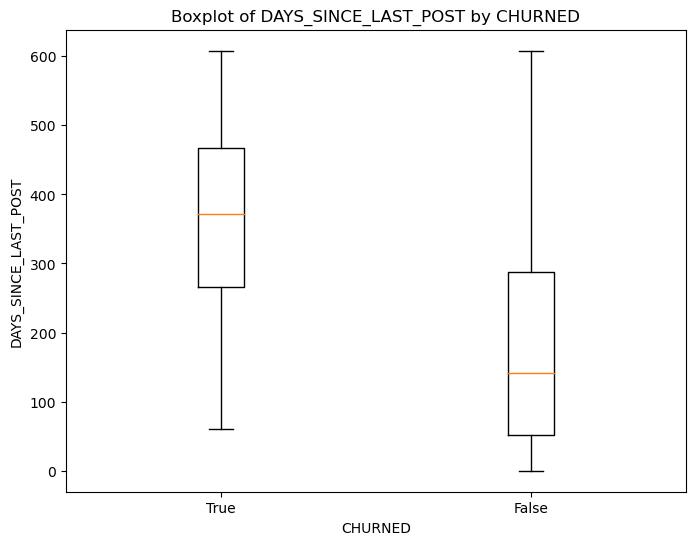

In [47]:
plt.figure(figsize=(8, 6))
plt.boxplot([df.loc[df.CHURNED==True,'DAYS_SINCE_LAST_POST'], df.loc[df.CHURNED==False,'DAYS_SINCE_LAST_POST']], labels=['True', 'False'])
plt.xlabel('CHURNED')
plt.ylabel('DAYS_SINCE_LAST_POST')
plt.title('Boxplot of DAYS_SINCE_LAST_POST by CHURNED')
plt.show()

In [48]:
df.groupby('CHURNED').DAYS_SINCE_LAST_POST.describe()

,count,mean,std,min,25%,50%,75%,max
CHURNED,,,,,,,,
False,25000.0,183.72244,153.071503,0.0,52.0,142.0,288.0,608.0
True,25000.0,362.84052,132.125059,61.0,266.0,371.0,467.0,608.0


In [101]:
# Category for users based on amount of posts
conditions = [
    (df['DAYS_SINCE_LAST_POST'] < 60),
    (df['DAYS_SINCE_LAST_POST'] >= 60) & (df['DAYS_SINCE_LAST_POST'] < 120),
    (df['DAYS_SINCE_LAST_POST'] >= 120) & (df['DAYS_SINCE_LAST_POST'] < 210),
    (df['DAYS_SINCE_LAST_POST'] >= 210)
]
categories = ['Last 60d', 'Last 120d', 'Last 210d', 'No post for over 210d']

# Use np.where to create the 'Category' column
df['LAST_POST_CAT'] = np.select(conditions, categories, default='Unknown')

pd.crosstab(df['CHURNED'], df['LAST_POST_CAT'])

LAST_POST_CAT,Last 120d,Last 210d,Last 60d,No post for over 210d
CHURNED,,,,
False,4172,4404,7007,9417
True,1022,2509,0,21469


### 3.3.3 Likes

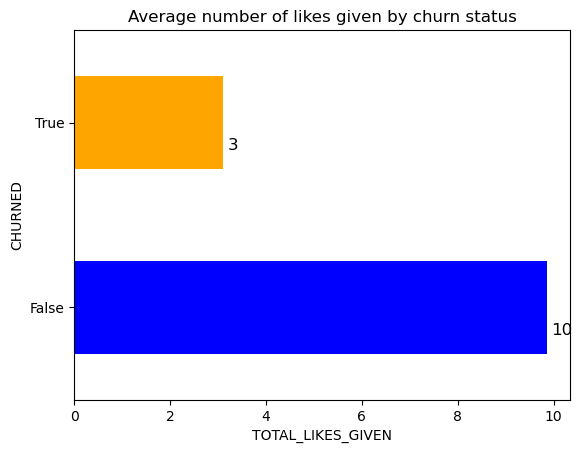

In [50]:
# churn vs. average number of likes given
ax = df.groupby('CHURNED')['TOTAL_LIKES_GIVEN'].mean().plot.barh(color=['blue', 'orange'])
plt.xlabel('TOTAL_LIKES_GIVEN')
plt.title('Average number of likes given by churn status')

# Add labels to the bars
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + 0.1, f'{i.get_width():.0f}', fontsize=12, color='black')


# Show the plot
plt.show()

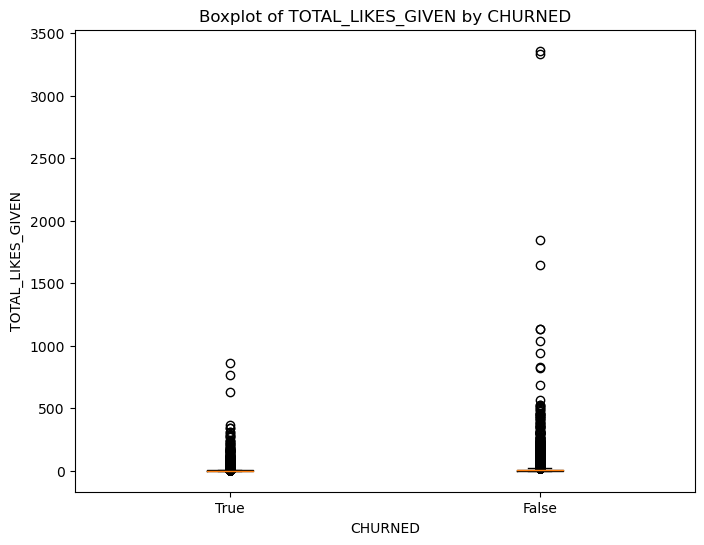

In [51]:
plt.figure(figsize=(8, 6))
plt.boxplot([df.loc[df.CHURNED==True,'TOTAL_LIKES_GIVEN'], df.loc[df.CHURNED==False,'TOTAL_LIKES_GIVEN']], labels=['True', 'False'])
plt.xlabel('CHURNED')
plt.ylabel('TOTAL_LIKES_GIVEN')
plt.title('Boxplot of TOTAL_LIKES_GIVEN by CHURNED')
plt.show()

In [52]:
df.groupby('CHURNED').TOTAL_LIKES_GIVEN.describe()

,count,mean,std,min,25%,50%,75%,max
CHURNED,,,,,,,,
False,25000.0,9.85240,45.450888,0.0,0.0,2.0,8.0,3359.0
True,25000.0,3.11144,13.958548,0.0,0.0,1.0,3.0,858.0


In [53]:
# Removing outliers
df_no_outliers = df[df['TOTAL_LIKES_GIVEN'] < 500]
df_no_outliers.groupby('CHURNED').TOTAL_LIKES_GIVEN.describe()

,count,mean,std,min,25%,50%,75%,max
CHURNED,,,,,,,,
False,24983.0,9.061682,24.895929,0.0,0.0,2.0,8.0,494.0
True,24997.0,3.021723,11.258114,0.0,0.0,1.0,3.0,362.0


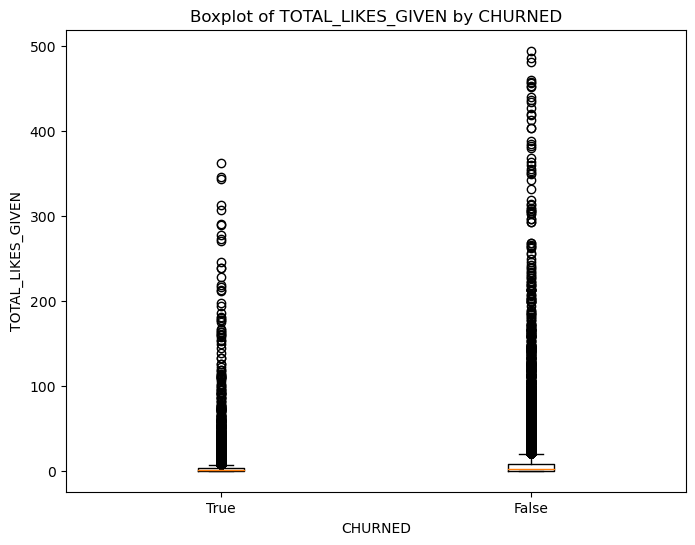

In [54]:
plt.figure(figsize=(8, 6))
plt.boxplot([df_no_outliers.loc[df_no_outliers.CHURNED==True,'TOTAL_LIKES_GIVEN'], df_no_outliers.loc[df.CHURNED==False,'TOTAL_LIKES_GIVEN']], labels=['True', 'False'])
plt.xlabel('CHURNED')
plt.ylabel('TOTAL_LIKES_GIVEN')
plt.title('Boxplot of TOTAL_LIKES_GIVEN by CHURNED')
plt.show()

# 4 Churn model

Considering the definition of churned user as: 
* We define a user "churned" if they did not visit within the last two months 

A good approximation is to consider a month having 30 days and therefore user churns if the amount of days since the last visit is equal or more than 60.


### Note regarding usefulness of the model
* At any given day, it is possible to calculate how many days have passed since the user's last visit, and compare it with our churn threshold of 60. _A prediction model is unnecessary to see who are the churned users of the current or past day(s)._

+ The code below is to show I can train a model using python, but I would never deploy this model because it was trained on a dataset with variables calculated with the same reference date as the churn calculation.

### Nomenclarute
- The date on which dataset was extracted, or created, is the _reference date_, which is for this excercise 2023-10-31.

- In this dataset, user activity that happened before up until the reference date is aggregated in the variables TOTAL_VISIT_COUNT, TOTAL_POST_COUNT and the other COUNT variables. Thus, the data could only be used for training a predictive model that aims to identify churned users on a future date, that is, after the reference date.

- I continue the exercise in that direction, but then it is not possible to assess any real model performance with this dataset. Because in the data there is no CHURNED flag calculated on such future date. 

### Alternative for training a model that goes to production
An alternative is to consider the CHURNED flag on the reference date as is, but calculate all the user activity variables based on another data extract, that filters data only up until another date, before the reference date. It could be a few days, weeks or months in advance of the churn calculation reference day. It should be enough in advance so that it allows for the execution and effect of a set of user retention strategies. That is:
* A predictive horizon is the time frame between the dataset extraction date and the date of the prediction outcome. The horizon should be aligned with business/marketing stakeholders who plan and execute the strategies for user retention.

#### Example of how the model task could be better defined: 
* Create a model to predict the probability of users to churn on 2023-10-31. Considering the churn definition as given, and the training data only the user activity up to 3 days before the churn calculation date. For this example, I am choosing to work with a **3-day predictive horizon.**
  * user activity reference date = 2023-10-28

Note, I don't have domain expertise in a product such as yours (discussion forum), rather in retail and e-commerce. I believe the user retention campaigns are very distinct. I would like to hear from you, if 3 days in advance makes sense for your business. 

  * Training data: all activity up to 2023-10-28 for the users that registered in the platform from 2022-02-27 to 2023-03-01. 
  * Target: predict churn status on 2023-10-31

#### Model choice: logistic regression

It fits with the problem at hand, to classify a boolean variable. Logistic regression provides a probability score, thus my model will be able to give a probability of churn for each user.

This is my first choice when working with numerical variables and prediction of a boolean variable, which are both the case here.
It is also an efficient model that doesn't require high computation power and doesn't require scaling of the features. I get results quickly.
Finally, its results are easily interpretable: we can check the coefficient of each feature to understand their individiual impact in the final probability score. It is also possible to check if the features are statistically significant to the model, by looking at ach of their  p-value.

### Training and test set

I will train two independent models to show the issue with the proposed task in practice:
- A) Use the variable days passed since last visit
- B) Do not use the variable days passed since last visit

### Model A

In [53]:
# moderate or high relationship variables only
# Model A with days passed since last vist
variables_for_churn_prediction_a = ['TOTAL_VISIT_COUNT','DAYS_SINCE_LAST_POST','DAYS_SINCE_LAST_VISIT']

X = df[variables_for_churn_prediction_a]
y = df['CHURNED_INT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

logreg_a = LogisticRegression(random_state=42)
logreg_a.fit(X_train, y_train)

y_pred_a = logreg_a.predict(X_test)
cnf_matrix_a = metrics.confusion_matrix(y_test, y_pred_a)
cnf_matrix_a

array([[6328,    0],
       [   0, 6172]], dtype=int64)

In [54]:
logreg_a.classes_

array([0, 1], dtype=int64)

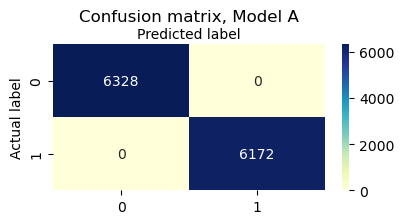

In [87]:
class_names = ['Non-Churned','Churned'] 

fig, ax = plt.subplots(figsize=(4,2))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


sns.heatmap(pd.DataFrame(cnf_matrix_a), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix, Model A', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [56]:
print(metrics.classification_report(y_test, y_pred_a, target_names=class_names))

              precision    recall  f1-score   support

 Non-Churned       1.00      1.00      1.00      6328
     Churned       1.00      1.00      1.00      6172

    accuracy                           1.00     12500
   macro avg       1.00      1.00      1.00     12500
weighted avg       1.00      1.00      1.00     12500



In [77]:
metrics.r2_score(y_test,y_pred_a)

1.0

In [63]:
from sklearn.feature_selection import f_regression

f_statistic, p_values = f_regression(X_train, y_train)

for p in p_values:
    print(p)

0.0
0.0
0.0


All variables are statistically significant, since the p-values are lower than the significance value 0.05

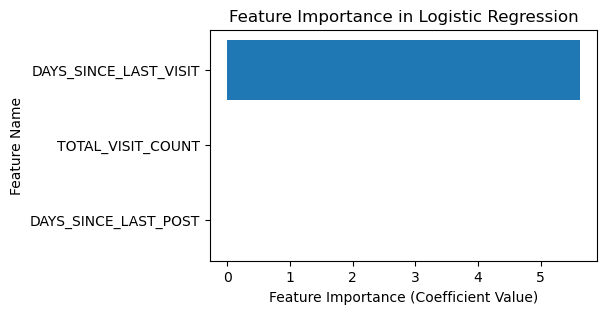

In [82]:
# Feature importance
sorted_indices = np.argsort(logreg_a.coef_[0])

plt.figure(figsize=(5, 3))
plt.barh([logreg_a.feature_names_in_[i] for i in sorted_indices], logreg_a.coef_[0][sorted_indices])
plt.xlabel('Feature Importance (Coefficient Value)')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [72]:
logreg_a.feature_names_in_

array(['TOTAL_VISIT_COUNT', 'DAYS_SINCE_LAST_POST',
       'DAYS_SINCE_LAST_VISIT'], dtype=object)

In [80]:
logreg_a.coef_[0]

array([ 2.03752356e-03, -6.03650727e-04,  5.61796485e+00])

In [92]:
logreg_a.intercept_

array([-345.63696541])

### Model B
Without days passed since last vist

In [83]:
# moderate or high relationship variables only
# Model B without days passed since last vist
variables_for_churn_prediction_b = ['TOTAL_VISIT_COUNT','DAYS_SINCE_LAST_POST']

X = df[variables_for_churn_prediction_b]
y = df['CHURNED_INT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

logreg_b = LogisticRegression(random_state=42)
logreg_b.fit(X_train, y_train)

y_pred_b = logreg_b.predict(X_test)
cnf_matrix_b = metrics.confusion_matrix(y_test, y_pred_b)
cnf_matrix_b

array([[4871, 1457],
       [ 977, 5195]], dtype=int64)

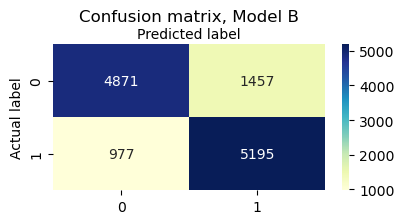

In [84]:
class_names = [False,True] 

fig, ax = plt.subplots(figsize=(4,2))
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)


sns.heatmap(pd.DataFrame(cnf_matrix_b), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix, Model B', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [88]:
print(metrics.classification_report(y_test, y_pred_b, target_names=class_names))

              precision    recall  f1-score   support

 Non-Churned       0.83      0.77      0.80      6328
     Churned       0.78      0.84      0.81      6172

    accuracy                           0.81     12500
   macro avg       0.81      0.81      0.81     12500
weighted avg       0.81      0.81      0.81     12500



In [89]:
metrics.r2_score(y_test,y_pred_b)

0.22099867023128794

R-squared measures the scatter of the data around the regression lines. The value is between 0 and 1.
- Low R-squared values can warn of imprecise predictions.
- Low R-squared => high variability

In [90]:
f_statistic, p_values = f_regression(X_train, y_train)

for p in p_values:
    print(p)

0.0
0.0


All variables are statistically significant, since the p-values are lower than the significance value 0.05

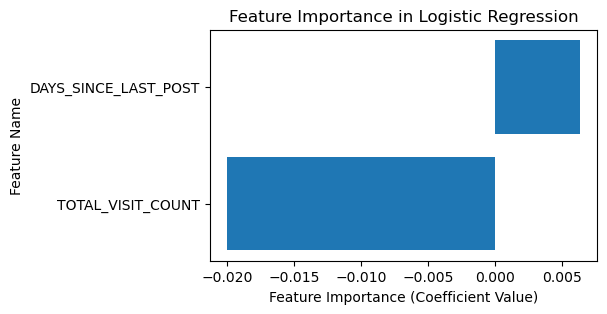

In [94]:
# Feature importance
sorted_indices = np.argsort(logreg_b.coef_[0])

plt.figure(figsize=(5, 3))
plt.barh([logreg_b.feature_names_in_[i] for i in sorted_indices], logreg_b.coef_[0][sorted_indices])
plt.xlabel('Feature Importance (Coefficient Value)')
plt.ylabel('Feature Name')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [96]:
logreg_b.feature_names_in_

array(['TOTAL_VISIT_COUNT', 'DAYS_SINCE_LAST_POST'], dtype=object)

In [95]:
logreg_b.coef_

array([[-0.02001596,  0.00633544]])

In [93]:
logreg_b.intercept_

array([-0.5279225])

#### Interpretation of feature importance
- TOTAL_VISIT_COUNT has a negative coefficient, that is, the more visits, lower the probability is of a user to churn. The weight is approx. 3x bigger (absolute value) if compared to the impact of the feature DAYS_SINCE_LAST_POST.
- DAYS_SINCE_LAST_POST has a positive coefficient, that is, the more days have passed since the users' last post, the higher the probability of a user to churn. The weight is approx. 3x smaller (absolute values) if compared to the impact of the feature TOTAL_VISIT_COUNT.

# 5 Strategies for user retention

Based on the model B and EDA:
- Encourage users to have more visits in the platform -> higher the number of visits, less chance of churning.
- Encourage users to post something new on the platform each 142.0 days (median of the variable for non-churned users).

Based on the correlation analysis:
- Encourage users to visit the platform to answer/comment to another users' post
- Encourage users to post more on the platform (>3 posts since they registered)

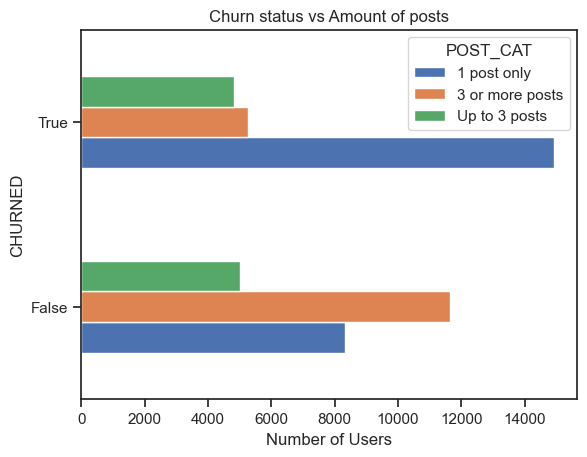

In [271]:
df_no_outliers.groupby('CHURNED')['POST_CAT'].value_counts().unstack().plot.barh();
plt.title('Churn status vs Amount of posts')
plt.xlabel('Number of Users');

We see more users that churned with one post only, while more users that did not churn have 3 or more posts